In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential,models
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path ="Face Mask Dataset/"

In [3]:
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,Face Mask Dataset/Test/WithMask/1612.png,WithMask,Test
1,Face Mask Dataset/Test/WithMask/768.png,WithMask,Test
2,Face Mask Dataset/Test/WithMask/Augmented_708_...,WithMask,Test
3,Face Mask Dataset/Test/WithMask/Augmented_756_...,WithMask,Test
4,Face Mask Dataset/Test/WithMask/Augmented_254_...,WithMask,Test


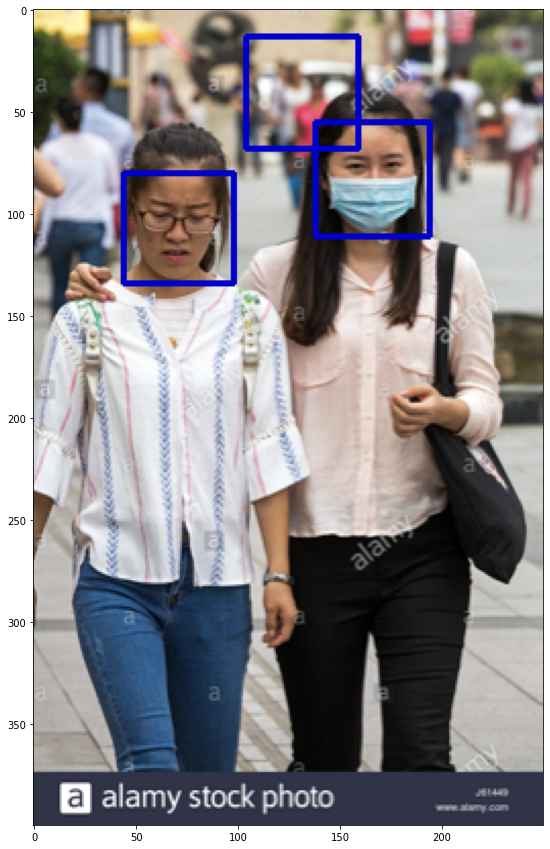

In [4]:
face_model=cv2.CascadeClassifier('cascade/haarcascade_frontalface_default.xml')

img=cv2.imread('archive/images/Input/maksssksksss352.png')

img = cv2.cvtColor(img,cv2.IMREAD_GRAYSCALE)

detected_face=face_model.detectMultiScale(img)

output_img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

for(x,y,w,h) in detected_face:
    cv2.rectangle(output_img,(x,y),(x+w,y+h),(0,0,200),2)

plt.figure(figsize=(15,15))
plt.imshow(output_img)

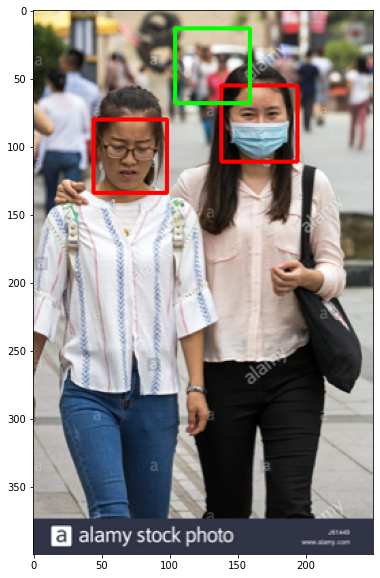

In [5]:
if len(detected_face)>=2:
    label=[0 for i in range(len(detected_face))]
    for i in range(len(detected_face)):
        for j in range(i+1,len(detected_face)):
            dist=distance.euclidean(detected_face[i][:2],detected_face[j][:2])
            if dist<130:
                label[i]=1
                label[j]=2
                
new_img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

for i in range(len(detected_face)):
    (x,y,w,h)=detected_face[i]
    if label[i]==1:
        cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
    else:
        cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)

plt.figure(figsize=(10,10))
plt.imshow(new_img)

With Mask 5909
Without Mask 5883


<AxesSubplot:xlabel='mask_status', ylabel='count'>

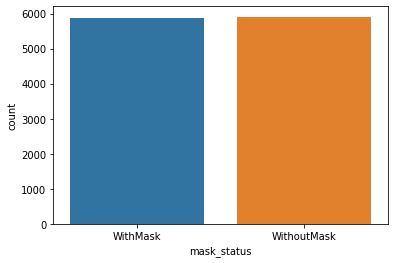

In [6]:
print(f"With Mask",dataset.value_counts('mask_status')[0])
print(f"Without Mask",dataset.value_counts('mask_status')[1])

sns.countplot(x=dataset['mask_status'])

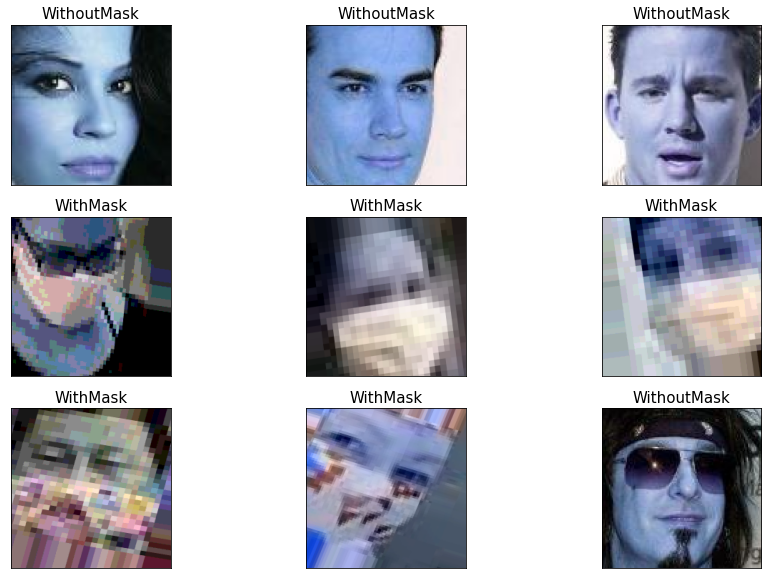

In [7]:
plt.figure(figsize=(15,10))

for i in range(9):
    random=np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.imread(dataset.loc[random,'image_path']))
    plt.title(dataset.loc[random,'mask_status'],size=15)
    plt.xticks([])
    plt.yticks([])

plt.show()    

In [8]:
train_df=dataset[dataset['where']=='Train']
test_df=dataset[dataset["where"]=='Test']
valid_df=dataset[dataset["where"]=='Validation']

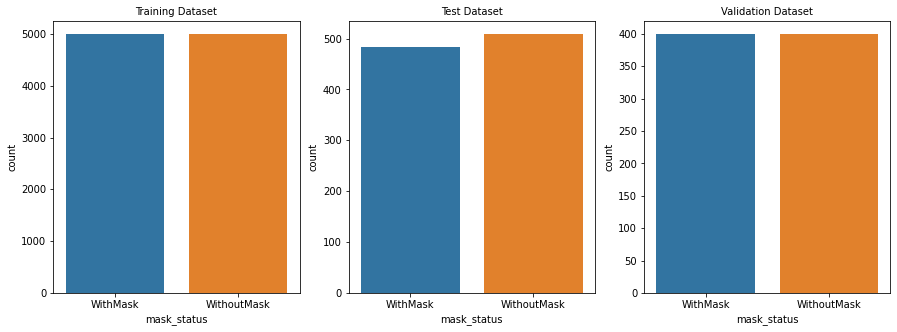

In [9]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [10]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,Face Mask Dataset/Train/WithMask/Augmented_494...,WithMask,Train
1,Face Mask Dataset/Train/WithMask/Augmented_354...,WithMask,Train
2,Face Mask Dataset/Train/WithMask/Augmented_309...,WithMask,Train
3,Face Mask Dataset/Train/WithMask/Augmented_276...,WithMask,Train
4,Face Mask Dataset/Train/WithMask/953.png,WithMask,Train


In [11]:
data=[]
image_size=150

for i in range(len(train_df)):
    img_array=cv2.imread(train_df['image_path'][i],cv2.IMREAD_GRAYSCALE)
    new_image_array=cv2.resize(img_array,(image_size,image_size))
    if train_df['mask_status'][i]=='WithMask':
        data.append([new_image_array,1])
    else:
        data.append([new_image_array,0])
        

In [12]:
data=np.array(data)

<ipython-input-12-dbfe0d9336db>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array(data)


In [13]:
np.random.shuffle(data)

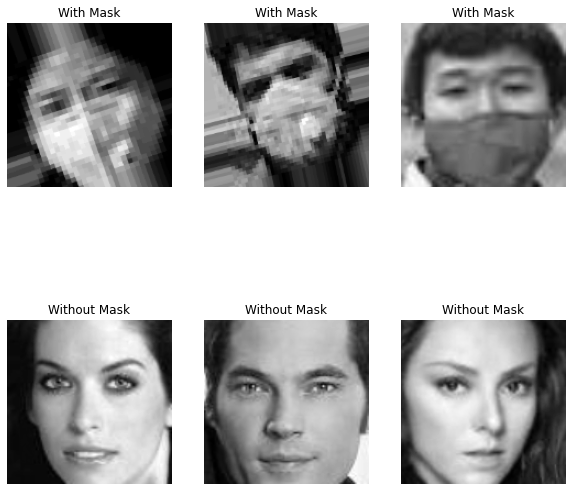

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")

In [15]:
X=[]
Y=[]

for image in data:
    X.append(image[0])
    Y.append(image[1])
    
X=np.array(X)
Y=np.array(Y)

In [16]:
X=X/255

X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=42)

In [17]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [18]:
model.compile(optimizer='adam',
             loss=tf.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [19]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

In [20]:
history=model.fit(X_train,Y_train,epochs=5,batch_size=32)

Epoch 1/5
250/250 [==============================] - 2336s 9s/step - loss: 0.3170 - accuracy: 0.8612
Epoch 2/5
250/250 [==============================] - 2443s 10s/step - loss: 0.0888 - accuracy: 0.9680
Epoch 3/5
250/250 [==============================] - 2433s 10s/step - loss: 0.0634 - accuracy: 0.9769
Epoch 4/5
250/250 [==============================] - 2435s 10s/step - loss: 0.0322 - accuracy: 0.9891
Epoch 5/5
250/250 [==============================] - 2436s 10s/step - loss: 0.0208 - accuracy: 0.9915
